In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.transforms import Compose, ToTensor
from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
import random
import math
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

# Loading data

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.n_samples = 0
        self.dataset = []
        self.load_audio_files(self.data_dir)
        
    def load_audio_files(self, path: str):
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:

                file_path = os.path.join(dirname, filename)
                label = dirname.split('/')[-1]
                label = torch.tensor([ord(label) - ord('a')])
                

                # Load audio
                waveform, sample_rate = torchaudio.load(file_path)
                if self.transform is not None:
                    waveform_transformed = self.transform(waveform)
                
                if waveform_transformed.shape[2] != 64:
                    print("Wrong shape:", waveform_transformed.shape)
                    continue
                
                self.n_samples += 1
                self.dataset.append((waveform, label))

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        waveform, label = self.dataset[idx]
        return waveform, label

In [3]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=1024+512, win_length=1024, f_min = 100, f_max=2500)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('/kaggle/input/keyboard-sounds', transforms)

Wrong shape: torch.Size([1, 64, 31])
Wrong shape: torch.Size([1, 64, 33])
Wrong shape: torch.Size([1, 64, 25])


In [4]:
train_size = 30 * 26 - 1 # 3 files were malformed
val_size = 10 * 26 - 1
test_size = 10 * 26 - 1
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data augmentation setup

In [5]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [6]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [7]:
aug_transforms = Compose([
    TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])
train_set = TrainingDataset(train_set, aug_transforms)
val_set = TrainingDataset(val_set, transforms)
test_set = TrainingDataset(test_set, transforms)

## Training set image (augmented)

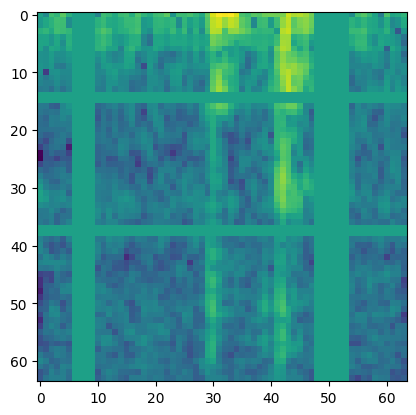

In [8]:
plt.imshow(train_set[0][0][0], cmap='viridis')

## Validation set image (not augmented)

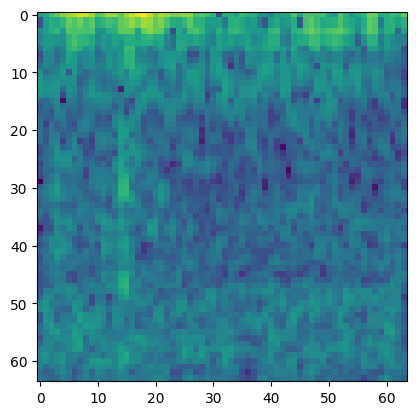

In [9]:
plt.imshow(transforms(dataset[2][0])[0], cmap='viridis')

# CoAtNet

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=26):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D
model = MyCoAtNet(nums_blocks, channels)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
!pip install torchsummary

In [22]:
# Taken from MyCoAtNet
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Taken from MyCoAtNet
model.apply(init_linear)
model.to(device);
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
from torchinfo import summary
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

Number of parameters: 24,025,606
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

# Training

In [24]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [26]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [27]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [28]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [29]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 18.21598243713379, Accuracy: 0.06418485237483953 Correct: 50 Total: 779 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.09266409266409266 Validation loss: 30.330785751342773 Correct: 24 Total: 259
Epoch [2/1100], Loss: 9.229609489440918, Accuracy: 0.10141206675224647 Correct: 79 Total: 779 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.08108108108108109 Validation loss: 17.28421401977539 Correct: 21 Total: 259
Epoch [3/1100], Loss: 12.007460594177246, Accuracy: 0.12708600770218229 Correct: 99 Total: 779 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.21621621621621623 Validation loss: 24.90836524963379 Correct: 56 Total: 259
Epoch [4/1100], Loss: 5.864416122436523, Accuracy: 0.1810012836970475 Correct: 141 Total: 779 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.22007722007722008 Validation loss: 9.723021507263184 Correct: 57 Total: 259
Epoch [5/1100], Loss: 6.794738292694092

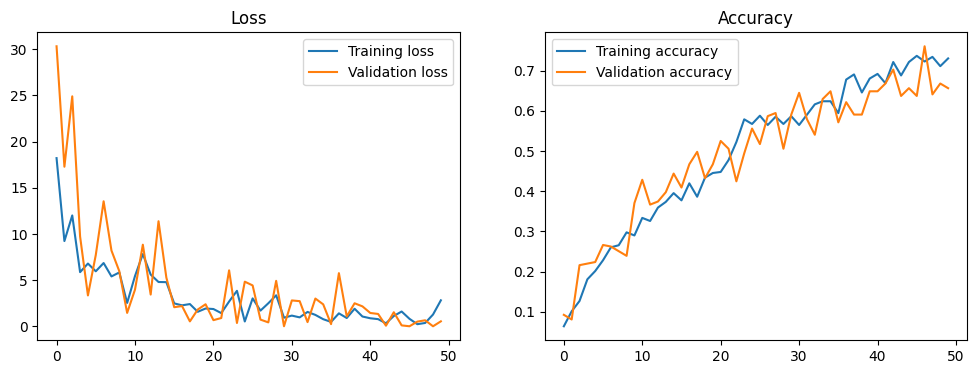

Epoch [51/1100], Loss: 1.099097728729248, Accuracy: 0.7317073170731707 Correct: 570 Total: 779 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7258687258687259 Validation loss: 1.2452834844589233 Correct: 188 Total: 259
Epoch [52/1100], Loss: 0.5355457067489624, Accuracy: 0.7394094993581515 Correct: 576 Total: 779 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.6911196911196911 Validation loss: 3.3236424922943115 Correct: 179 Total: 259
Epoch [53/1100], Loss: 0.40609320998191833, Accuracy: 0.7432605905006419 Correct: 579 Total: 779 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.7027027027027027 Validation loss: 1.8376563787460327 Correct: 182 Total: 259
Epoch [54/1100], Loss: 2.1765642166137695, Accuracy: 0.7689345314505777 Correct: 599 Total: 779 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.7027027027027027 Validation loss: 0.4249272644519806 Correct: 182 Total: 259
Epoch [55/

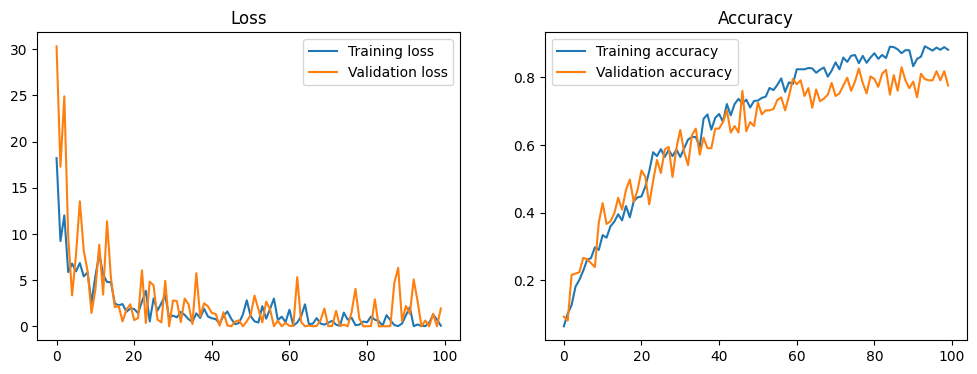

Epoch [101/1100], Loss: 0.010514462366700172, Accuracy: 0.8600770218228498 Correct: 670 Total: 779 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.803088803088803 Validation loss: 0.14232607185840607 Correct: 208 Total: 259
Epoch [102/1100], Loss: 0.08669281750917435, Accuracy: 0.8677792041078306 Correct: 676 Total: 779 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.7837837837837838 Validation loss: 2.150122880935669 Correct: 203 Total: 259
Epoch [103/1100], Loss: 0.3271627128124237, Accuracy: 0.8947368421052632 Correct: 697 Total: 779 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.7992277992277992 Validation loss: 1.8394399881362915 Correct: 207 Total: 259
Epoch [104/1100], Loss: 0.0411379300057888, Accuracy: 0.9165596919127086 Correct: 714 Total: 779 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.8146718146718147 Validation loss: 5.5389809858752415e-05 Correct: 211 Total: 259

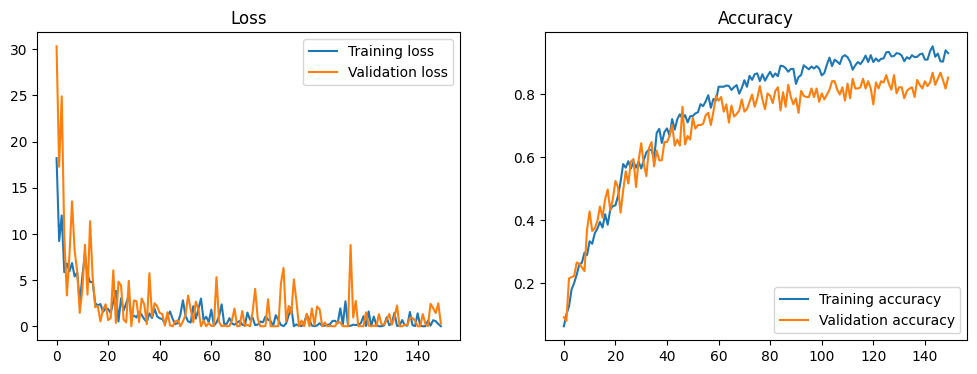

Epoch [151/1100], Loss: 0.2257208675146103, Accuracy: 0.9306803594351734 Correct: 725 Total: 779 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8648648648648649 Validation loss: 0.094561867415905 Correct: 224 Total: 259
Epoch [152/1100], Loss: 0.07575727254152298, Accuracy: 0.9435173299101413 Correct: 735 Total: 779 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.833976833976834 Validation loss: 4.159892559051514 Correct: 216 Total: 259
Epoch [153/1100], Loss: 0.3260573446750641, Accuracy: 0.9332477535301669 Correct: 727 Total: 779 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.7799227799227799 Validation loss: 0.010451712645590305 Correct: 202 Total: 259
Epoch [154/1100], Loss: 0.0024598920717835426, Accuracy: 0.9075738125802311 Correct: 707 Total: 779 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8455598455598455 Validation loss: 0.27552175521850586 Correct: 219 Total: 259
Ep

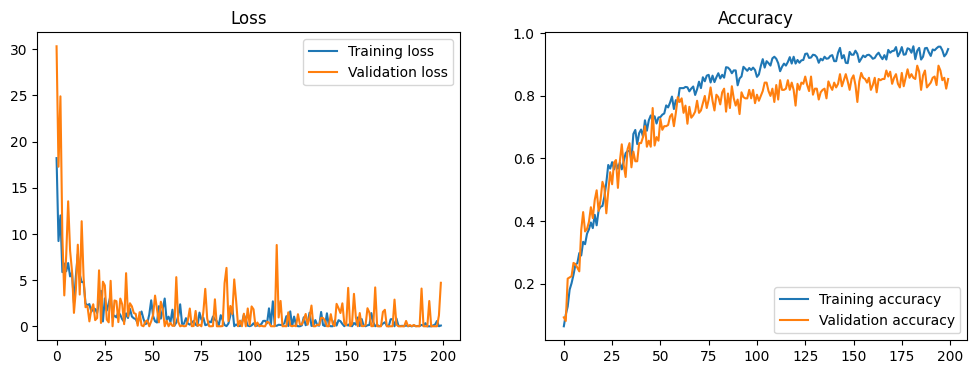

Epoch [201/1100], Loss: 0.002103296807035804, Accuracy: 0.9563543003851092 Correct: 745 Total: 779 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8764478764478765 Validation loss: 2.5730628967285156 Correct: 227 Total: 259
Epoch [202/1100], Loss: 2.580137697805185e-05, Accuracy: 0.9473684210526315 Correct: 738 Total: 779 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.8687258687258688 Validation loss: 1.6730965375900269 Correct: 225 Total: 259
Epoch [203/1100], Loss: 0.003696850035339594, Accuracy: 0.9332477535301669 Correct: 727 Total: 779 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8687258687258688 Validation loss: 2.2508416175842285 Correct: 225 Total: 259
Epoch [204/1100], Loss: 0.7536407113075256, Accuracy: 0.9499358151476252 Correct: 740 Total: 779 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8532818532818532 Validation loss: 1.1761799214582425e-05 Correct: 221 Tota

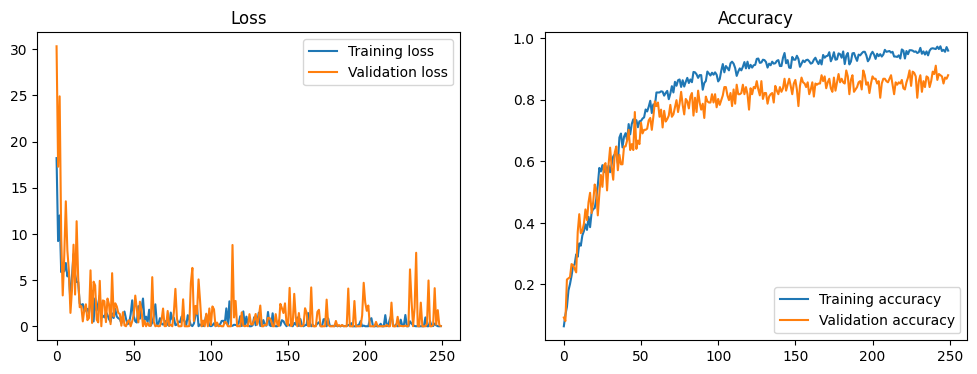

Epoch [251/1100], Loss: 1.0571428537368774, Accuracy: 0.9550706033376123 Correct: 744 Total: 779 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8494208494208494 Validation loss: 0.0004976139753125608 Correct: 220 Total: 259
Epoch [252/1100], Loss: 0.04046493023633957, Accuracy: 0.9512195121951219 Correct: 741 Total: 779 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.8764478764478765 Validation loss: 0.0007491922588087618 Correct: 227 Total: 259
Epoch [253/1100], Loss: 0.018088743090629578, Accuracy: 0.944801026957638 Correct: 736 Total: 779 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.861003861003861 Validation loss: 0.12811483442783356 Correct: 223 Total: 259
Epoch [254/1100], Loss: 0.024704694747924805, Accuracy: 0.9537869062901155 Correct: 743 Total: 779 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.8803088803088803 Validation loss: 2.7320964336395264 Correct: 228 Total

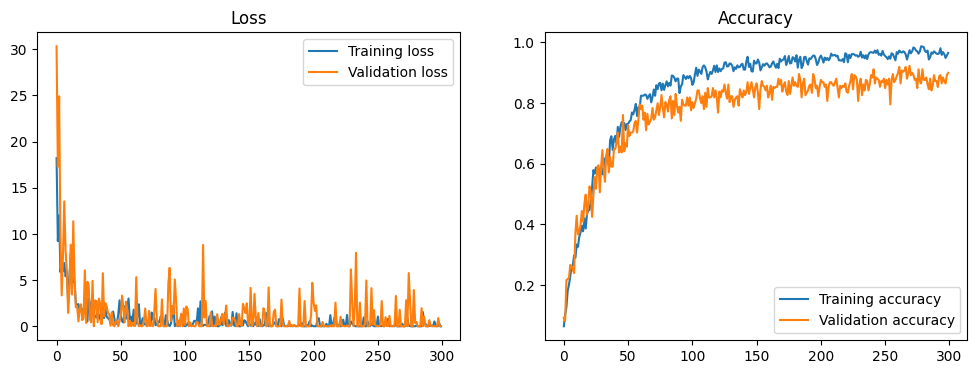

Epoch [301/1100], Loss: 0.017004234716296196, Accuracy: 0.9640564826700898 Correct: 751 Total: 779 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8996138996138996 Validation loss: 0.0 Correct: 233 Total: 259
Epoch [302/1100], Loss: 0.002742496319115162, Accuracy: 0.9768934531450578 Correct: 761 Total: 779 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8957528957528957 Validation loss: 0.06860937923192978 Correct: 232 Total: 259
Epoch [303/1100], Loss: 0.01823955588042736, Accuracy: 0.9794608472400513 Correct: 763 Total: 779 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.8996138996138996 Validation loss: 9.337930350739043e-06 Correct: 233 Total: 259
Epoch [304/1100], Loss: 0.09233608096837997, Accuracy: 0.9717586649550706 Correct: 757 Total: 779 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.8764478764478765 Validation loss: 1.2581442594528198 Correct: 227 Total: 259
Epoch [30

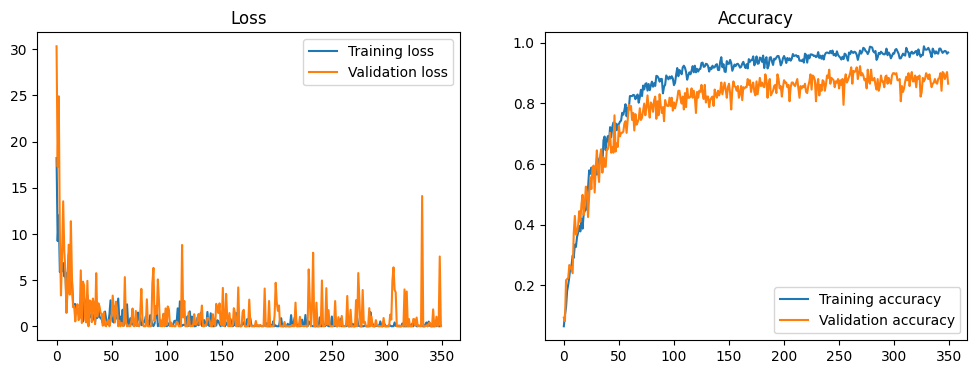

Epoch [351/1100], Loss: 0.046230461448431015, Accuracy: 0.9794608472400513 Correct: 763 Total: 779 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8687258687258688 Validation loss: 0.0 Correct: 225 Total: 259
Epoch [352/1100], Loss: 0.1884126216173172, Accuracy: 0.9666238767650834 Correct: 753 Total: 779 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9111969111969112 Validation loss: 9.947785377502441 Correct: 236 Total: 259
Epoch [353/1100], Loss: 0.10806310176849365, Accuracy: 0.9691912708600771 Correct: 755 Total: 779 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8648648648648649 Validation loss: 0.0 Correct: 224 Total: 259
Epoch [354/1100], Loss: 0.0006851993384771049, Accuracy: 0.9794608472400513 Correct: 763 Total: 779 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.888030888030888 Validation loss: 1.4702155567647424e-05 Correct: 230 Total: 259
Epoch [355/1100], Loss: 0.000

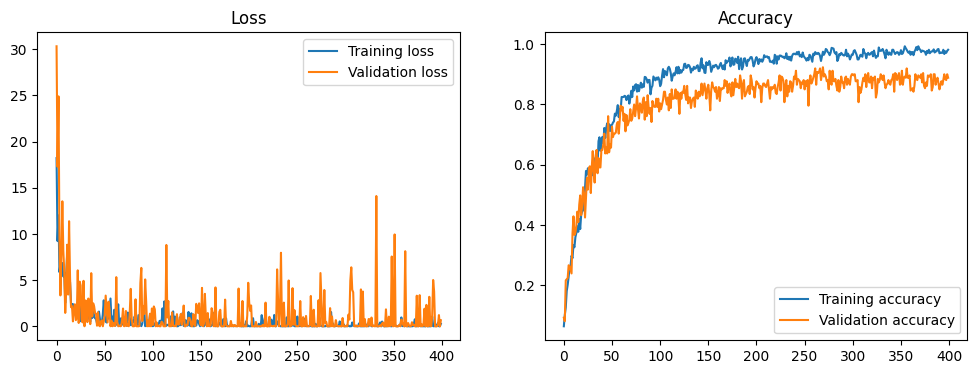

Epoch [401/1100], Loss: 6.39394215795619e-07, Accuracy: 0.975609756097561 Correct: 760 Total: 779 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.8532818532818532 Validation loss: 0.7538580894470215 Correct: 221 Total: 259
Epoch [402/1100], Loss: 2.5400653612450697e-05, Accuracy: 0.9833119383825417 Correct: 766 Total: 779 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.8803088803088803 Validation loss: 0.0 Correct: 228 Total: 259
Epoch [403/1100], Loss: 0.21487173438072205, Accuracy: 0.9576379974326059 Correct: 746 Total: 779 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8687258687258688 Validation loss: 3.1789133458914876e-07 Correct: 225 Total: 259
Epoch [404/1100], Loss: 5.526893346541328e-06, Accuracy: 0.9768934531450578 Correct: 761 Total: 779 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.8725868725868726 Validation loss: 0.7775973677635193 Correct: 226 Total: 259
Epoch 

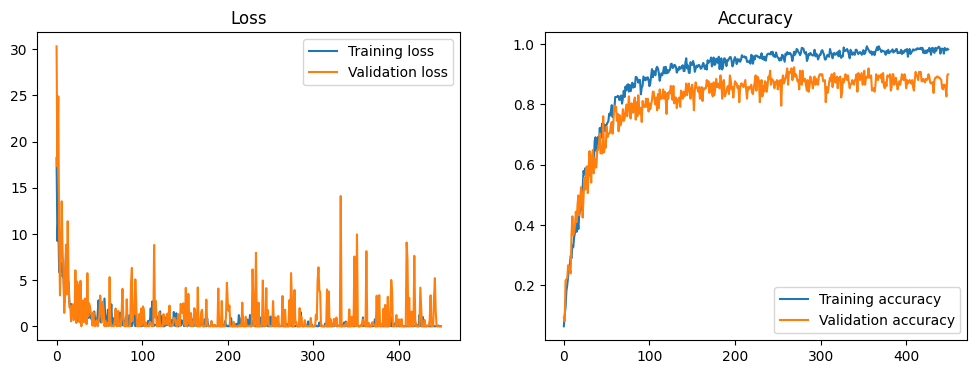

Epoch [451/1100], Loss: 0.0005313519504852593, Accuracy: 0.982028241335045 Correct: 765 Total: 779 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.8764478764478765 Validation loss: 1.0581356287002563 Correct: 227 Total: 259
Epoch [452/1100], Loss: 0.004029483068734407, Accuracy: 0.9833119383825417 Correct: 766 Total: 779 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.8841698841698842 Validation loss: 2.7815406156150857e-06 Correct: 229 Total: 259
Epoch [453/1100], Loss: 0.24896496534347534, Accuracy: 0.9768934531450578 Correct: 761 Total: 779 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.8725868725868726 Validation loss: 5.9087748527526855 Correct: 226 Total: 259
Epoch [454/1100], Loss: 0.06759849935770035, Accuracy: 0.9807445442875481 Correct: 764 Total: 779 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.8803088803088803 Validation loss: 7.947276685627003e-07 Correct: 228 Tota

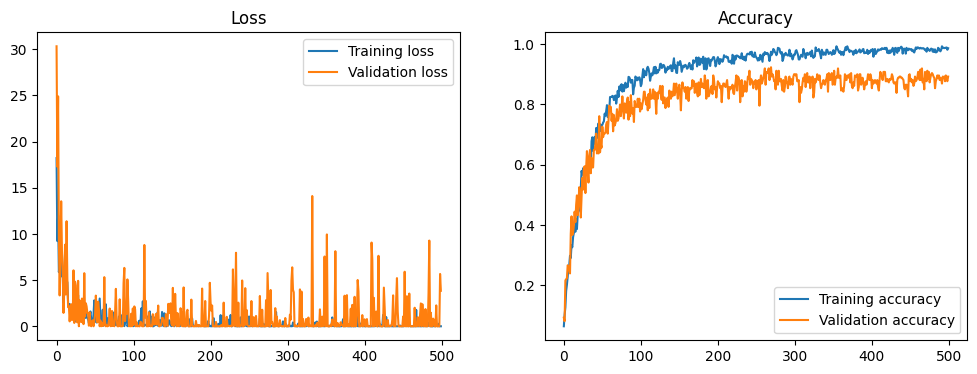

Epoch [501/1100], Loss: 2.6526906367507763e-05, Accuracy: 0.9833119383825417 Correct: 766 Total: 779 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.8918918918918919 Validation loss: 1.5131438970565796 Correct: 231 Total: 259
Epoch [502/1100], Loss: 0.00013888318790122867, Accuracy: 0.9871630295250321 Correct: 769 Total: 779 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.8803088803088803 Validation loss: 5.563095442084887e-07 Correct: 228 Total: 259
Epoch [503/1100], Loss: 0.035211581736803055, Accuracy: 0.9781771501925546 Correct: 762 Total: 779 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.8803088803088803 Validation loss: 3.1477019786834717 Correct: 228 Total: 259
Epoch [504/1100], Loss: 0.03683042898774147, Accuracy: 0.9807445442875481 Correct: 764 Total: 779 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.8648648648648649 Validation loss: 3.917668342590332 Correct: 224 To

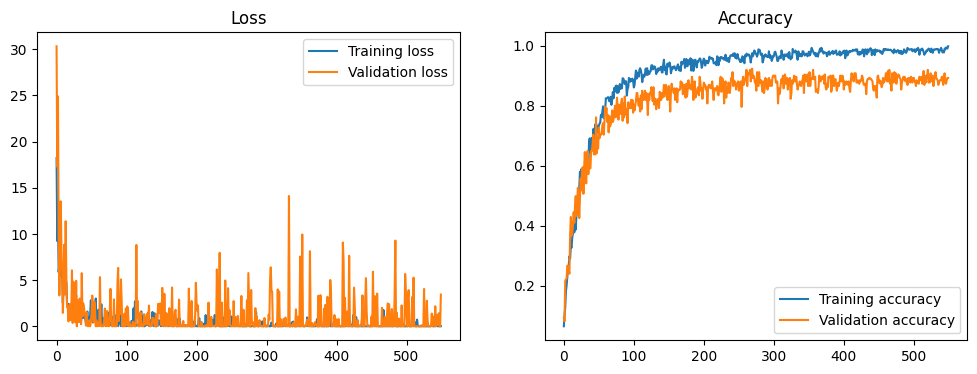

Epoch [551/1100], Loss: 0.00014160013233777136, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.8918918918918919 Validation loss: 3.5054731369018555 Correct: 231 Total: 259
Epoch [552/1100], Loss: 0.047604311257600784, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.8764478764478765 Validation loss: 0.0002911805349867791 Correct: 227 Total: 259
Epoch [553/1100], Loss: 4.455739326658659e-05, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.8996138996138996 Validation loss: 0.0 Correct: 233 Total: 259
Epoch [554/1100], Loss: 1.8748290813164203e-06, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.8957528957528957 Validation loss: 0.0 Correct: 232 Total: 259
Epoch [555/1100], Lo

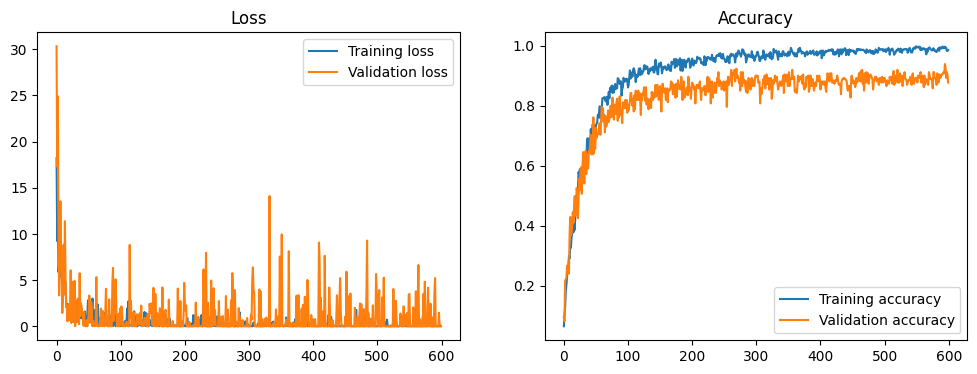

Epoch [601/1100], Loss: 6.296026549534872e-05, Accuracy: 0.982028241335045 Correct: 765 Total: 779 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.8648648648648649 Validation loss: 2.169569779653102e-05 Correct: 224 Total: 259
Epoch [602/1100], Loss: 0.001974785467609763, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.861003861003861 Validation loss: 0.014994465745985508 Correct: 223 Total: 259
Epoch [603/1100], Loss: 2.492529347364325e-06, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.8764478764478765 Validation loss: 4.588162899017334 Correct: 227 Total: 259
Epoch [604/1100], Loss: 0.1023329421877861, Accuracy: 0.9871630295250321 Correct: 769 Total: 779 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.8648648648648649 Validation loss: 0.006039606872946024 Correct: 224 To

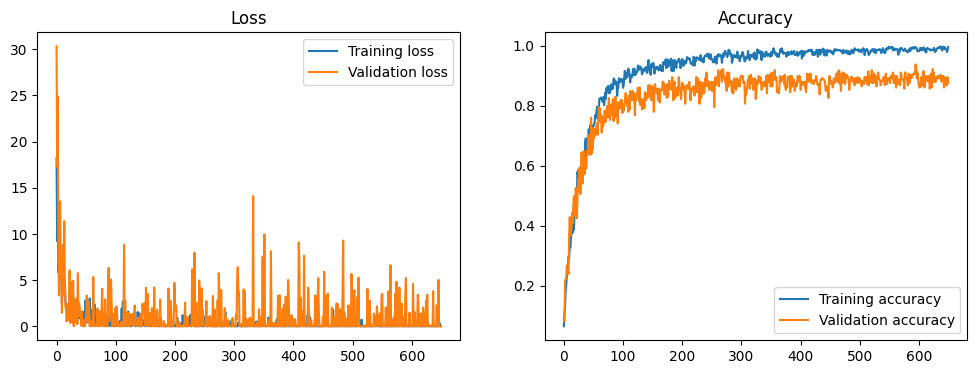

Epoch [651/1100], Loss: 4.204751348879654e-06, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.8996138996138996 Validation loss: 7.94728478581419e-08 Correct: 233 Total: 259
Epoch [652/1100], Loss: 1.5940582670737058e-05, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.8996138996138996 Validation loss: 2.3841850804728892e-07 Correct: 233 Total: 259
Epoch [653/1100], Loss: 5.4081392590887845e-05, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.8764478764478765 Validation loss: 1.54571116581792e-05 Correct: 227 Total: 259
Epoch [654/1100], Loss: 0.008198253810405731, Accuracy: 0.9858793324775353 Correct: 768 Total: 779 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9111969111969112 Validation loss: 3.973642748178463e-08 Corre

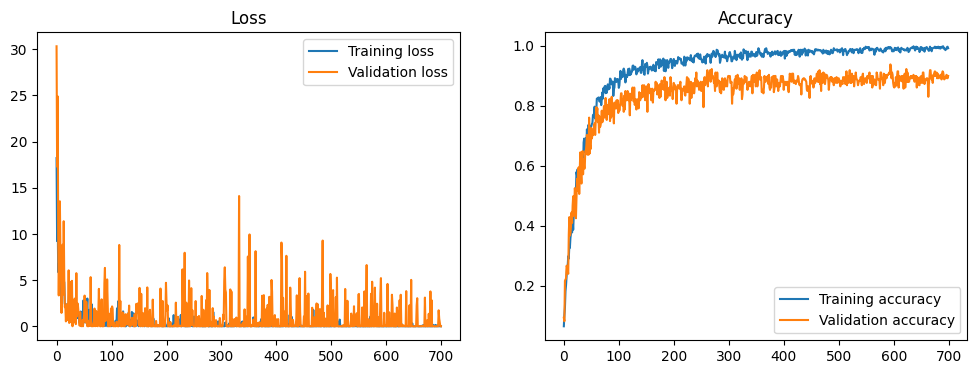

Epoch [701/1100], Loss: 8.167616761056706e-05, Accuracy: 0.9910141206675225 Correct: 772 Total: 779 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.8841698841698842 Validation loss: 0.3352203667163849 Correct: 229 Total: 259
Epoch [702/1100], Loss: 0.0009001957369036973, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9073359073359073 Validation loss: 0.0452314056456089 Correct: 235 Total: 259
Epoch [703/1100], Loss: 0.12605129182338715, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9034749034749034 Validation loss: 1.8039851056528278e-05 Correct: 234 Total: 259
Epoch [704/1100], Loss: 5.221824540058151e-05, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9073359073359073 Validation loss: 0.01598162017762661 Correct: 235 

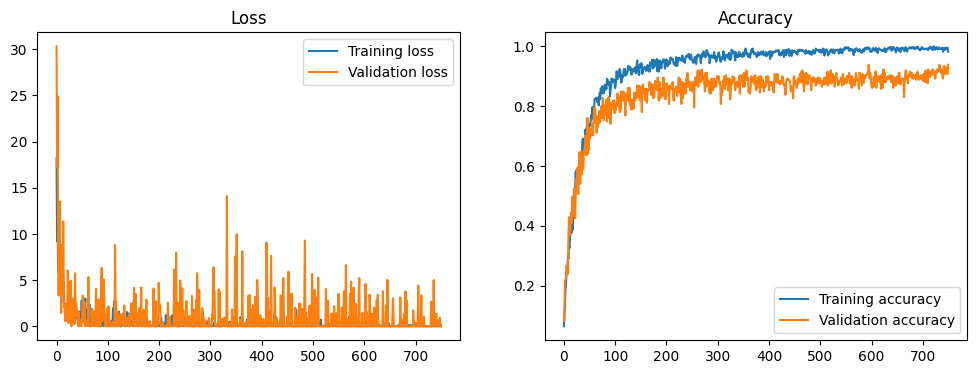

Epoch [751/1100], Loss: 7.3149390118487645e-06, Accuracy: 0.9845956354300385 Correct: 767 Total: 779 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9305019305019305 Validation loss: 0.04103093594312668 Correct: 241 Total: 259
Epoch [752/1100], Loss: 0.09691960364580154, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9343629343629344 Validation loss: 0.0023960645776242018 Correct: 242 Total: 259
Epoch [753/1100], Loss: 0.26375269889831543, Accuracy: 0.9871630295250321 Correct: 769 Total: 779 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9266409266409267 Validation loss: 2.781549426345009e-07 Correct: 240 Total: 259
Epoch [754/1100], Loss: 0.006706597283482552, Accuracy: 0.9897304236200257 Correct: 771 Total: 779 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.918918918918919 Validation loss: 0.0 Correct: 238 Total: 259
Epoc

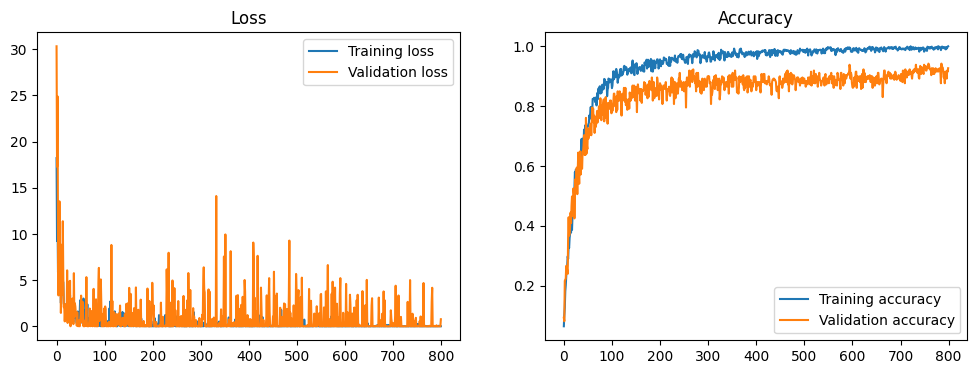

Epoch [801/1100], Loss: 7.063290831865743e-05, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9343629343629344 Validation loss: 2.1663854122161865 Correct: 242 Total: 259
Epoch [802/1100], Loss: 4.724925929622259e-06, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9266409266409267 Validation loss: 6.357822712743655e-07 Correct: 240 Total: 259
Epoch [803/1100], Loss: 8.396318298764527e-05, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9111969111969112 Validation loss: 4.067612171173096 Correct: 236 Total: 259
Epoch [804/1100], Loss: 3.5654252314998303e-06, Accuracy: 0.993581514762516 Correct: 774 Total: 779 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.915057915057915 Validation loss: 4.521699156612158e-05 Correct: 237 T

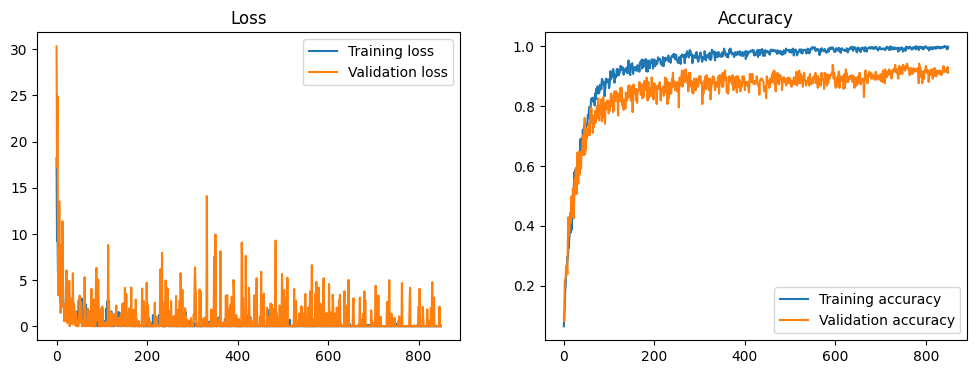

Epoch [851/1100], Loss: 8.008594704733696e-06, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9343629343629344 Validation loss: 2.0855112075805664 Correct: 242 Total: 259
Epoch [852/1100], Loss: 0.0008673345437273383, Accuracy: 1.0 Correct: 779 Total: 779 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9305019305019305 Validation loss: 0.00010071803262690082 Correct: 241 Total: 259
Epoch [853/1100], Loss: 7.592968904646114e-05, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9305019305019305 Validation loss: 0.0 Correct: 241 Total: 259
Epoch [854/1100], Loss: 0.36466360092163086, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9305019305019305 Validation loss: 5.327061176300049 Correct: 241 Total: 259
Epoch [855/1100], 

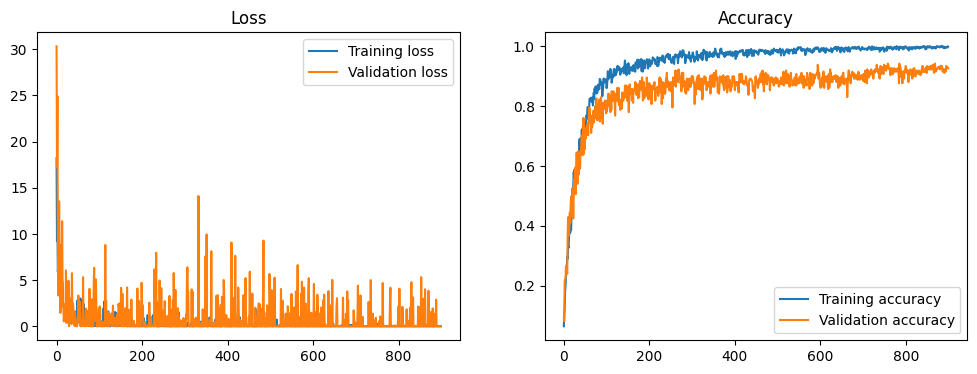

Epoch [901/1100], Loss: 0.01176333799958229, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.918918918918919 Validation loss: 0.4160570800304413 Correct: 238 Total: 259
Epoch [902/1100], Loss: 2.2928639737074263e-05, Accuracy: 1.0 Correct: 779 Total: 779 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 0.016712062060832977 Correct: 239 Total: 259
Epoch [903/1100], Loss: 0.00025133611052297056, Accuracy: 0.9987163029525032 Correct: 778 Total: 779 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9111969111969112 Validation loss: 0.007094321306794882 Correct: 236 Total: 259
Epoch [904/1100], Loss: 5.017537205276312e-06, Accuracy: 1.0 Correct: 779 Total: 779 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.915057915057915 Validation loss: 7.589604592794785e-06 Correct: 237 Total: 259
Epoch [905/1100], Los

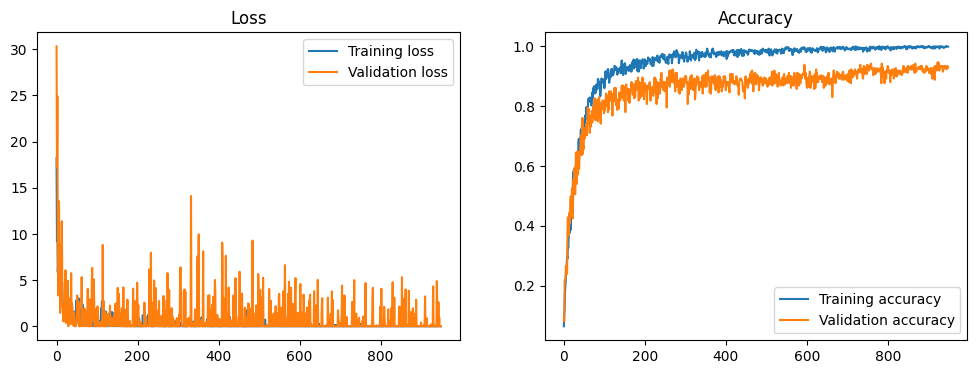

Epoch [951/1100], Loss: 1.874817826319486e-06, Accuracy: 0.9961489088575096 Correct: 776 Total: 779 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9266409266409267 Validation loss: 3.973642748178463e-08 Correct: 240 Total: 259
Epoch [952/1100], Loss: 4.811599410459166e-06, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 2.6264744519721717e-05 Correct: 239 Total: 259
Epoch [953/1100], Loss: 2.7417975161370123e-06, Accuracy: 0.9922978177150192 Correct: 773 Total: 779 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 0.0002929671318270266 Correct: 239 Total: 259
Epoch [954/1100], Loss: 0.44947004318237305, Accuracy: 0.9948652118100129 Correct: 775 Total: 779 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.915057915057915 Validation loss: 0.03908781707286835 Correct: 23

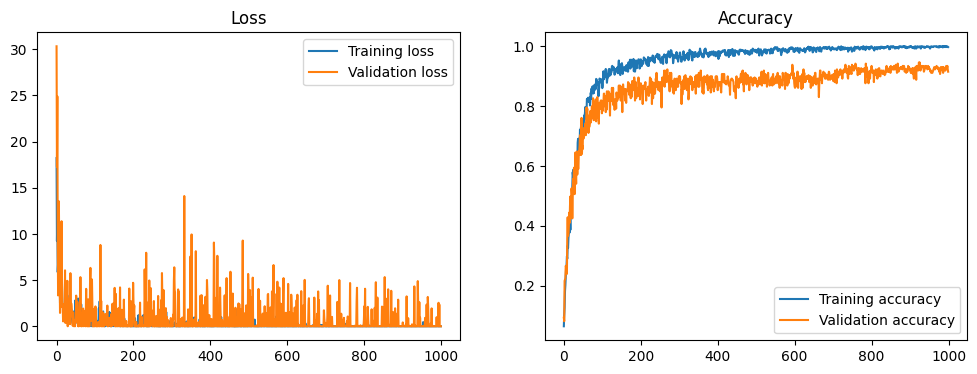

Epoch [1001/1100], Loss: 3.1860849958320614e-06, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9305019305019305 Validation loss: 0.0 Correct: 241 Total: 259
Epoch [1002/1100], Loss: 2.3841845120387006e-07, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9227799227799228 Validation loss: 1.0420688390731812 Correct: 239 Total: 259
Epoch [1003/1100], Loss: 9.428351290807768e-07, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9305019305019305 Validation loss: 1.0900593996047974 Correct: 241 Total: 259
Epoch [1004/1100], Loss: 0.0, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9266409266409267 Validation loss: 0.0 Correct: 240 Total: 259
Epoch [1005/1100], Loss: 4.226501744142297e-07, Accuracy: 1.0 Correct: 779 Total: 779 LR: 4.4549

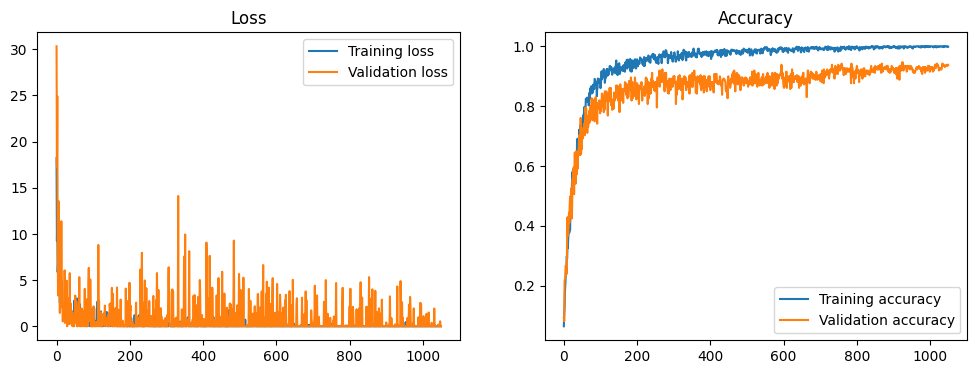

Epoch [1051/1100], Loss: 4.497351710597286e-06, Accuracy: 1.0 Correct: 779 Total: 779 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9382239382239382 Validation loss: 1.1920926823449918e-07 Correct: 243 Total: 259
Epoch [1052/1100], Loss: 2.2758126760891173e-07, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9420849420849421 Validation loss: 0.0012029854115098715 Correct: 244 Total: 259
Epoch [1053/1100], Loss: 3.9447036215278786e-06, Accuracy: 0.9974326059050064 Correct: 777 Total: 779 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9382239382239382 Validation loss: 0.0 Correct: 243 Total: 259
Epoch [1054/1100], Loss: 5.4186031661629386e-08, Accuracy: 1.0 Correct: 779 Total: 779 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9420849420849421 Validation loss: 5.52290839550551e-05 Correct: 244 Total: 259
Epoch [1055/1100], 

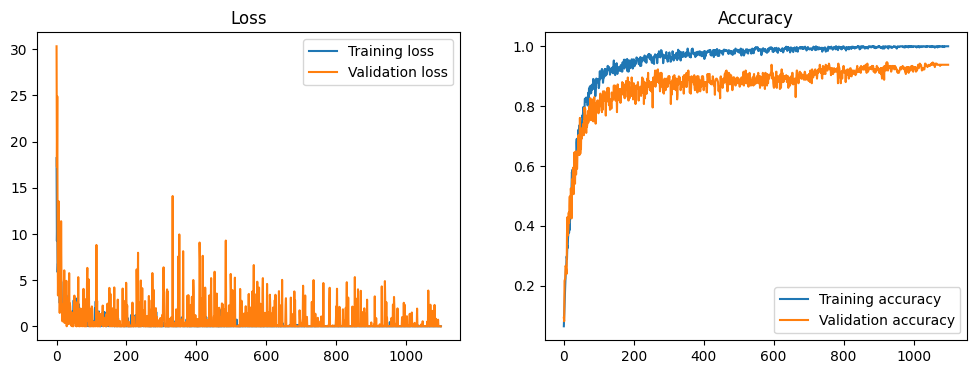

In [30]:
best_model_path = "/kaggle/working/CoAtNet-1-Best.pkl"
model_path = "/kaggle/working/CoAtNet-1.pkl"
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [31]:
save_model(model, model_path)

# Results

In [32]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [33]:
print("Best validation acc: ", max(val_accuracies))

Best validation acc:  0.9459459459459459


In [34]:
print("Last validation acc: ", val_accuracies[-1])

Last validation acc:  0.9382239382239382


In [35]:
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]
label_dict = {}
for i in range(ord('Z') - ord('A') + 1):
    label_dict[i] = alphabet[i]
print(label_dict)
len(alphabet)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


26

In [36]:
# Adapted from My_CoAtNet
predictions_path = '/kaggle/working/predictions.csv'
def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:
        character_lab = []
        character_pred = []
        
        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

## Test accuracy

In [37]:
cm = predict(test_dataloader)

Test Accuracy: 0.918918918918919


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
predicted_labels,U,N,B,E,I,M,R,V,H,G,P,O,A,G,V,O,H,U,K,J,G,A,O,B,F,H,H,O,N,U,M,D,P,K,Y,P,G,J,Q,L,K,D,E,Q,N,J,N,Y,T,Z,E,D,B,U,W,O,W,C,P,A,V,C,Z,N,G,T,U,C,U,O,B,W,C,T,C,C,R,O,I,A,S,B,K,J,I,R,S,M,W,C,Q,U,W,T,P,Y,C,B,N,L,Y,K,P,H,L,Y,P,N,C,J,Q,V,B,W,J,Z,M,O,Q,T,A,L,R,Z,F,J,U,T,K,H,A,B,T,I,G,X,V,M,Z,Q,G,O,O,E,T,K,A,S,I,V,K,A,Q,Z,V,Y,W,S,L,I,X,X,N,W,J,O,P,O,G,Q,Z,D,D,G,H,V,U,X,S,C,E,B,K,Q,I,X,S,J,H,X,F,W,L,A,X,S,O,D,D,V,I,J,I,Y,N,A,X,R,P,Q,B,Q,R,Y,L,V,R,X,W,O,V,X,S,C,V,X,Z,R,F,R,U,F,S,F,U,X,U,X,Q,F,N,I,G,M,W,K,M,S,J,S,J,E,J,A,O,S,K,X,O
true_labels,P,N,B,E,I,M,R,C,H,G,P,O,A,G,V,O,H,U,K,J,G,A,O,B,F,H,H,P,N,O,M,D,P,K,Y,P,G,J,Q,L,K,D,E,Q,N,J,J,Y,T,Z,E,D,B,E,W,O,W,C,P,A,C,C,Z,N,G,T,U,C,U,O,B,A,C,T,V,C,R,O,T,A,S,B,K,J,I,R,S,M,W,C,Q,U,W,T,P,Y,C,B,N,L,Y,K,P,H,L,Y,P,N,N,J,Q,V,B,W,J,Z,M,O,Q,T,A,K,R,Z,F,K,U,T,K,H,A,B,T,I,G,X,V,M,Z,Q,G,O,O,E,T,K,A,S,I,V,K,A,Q,Z,V,Y,W,S,K,P,X,X,N,W,J,O,P,O,G,Q,Z,D,D,G,H,V,U,X,S,C,E,B,K,Q,I,X,S,J,H,X,F,W,L,A,X,S,O,D,D,V,I,J,I,Y,N,A,G,R,P,Q,B,Q,R,Y,L,V,R,X,W,O,V,X,S,V,M,X,Z,R,F,R,U,F,S,F,U,Z,U,X,Q,F,N,I,G,M,W,K,M,S,B,S,J,E,J,A,P,S,K,X,O


0.918918918918919
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      0.91      0.95        11
           2       0.73      0.80      0.76        10
           3       1.00      1.00      1.00         7
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00         7
           6       1.00      0.91      0.95        11
           7       1.00      1.00      1.00         8
           8       0.80      1.00      0.89         8
           9       0.85      0.92      0.88        12
          10       1.00      0.79      0.88        14
          11       0.71      1.00      0.83         5
          12       1.00      0.88      0.93         8
          13       0.90      0.90      0.90        10
          14       0.88      0.93      0.90        15
          15       1.00      0.69      0.82        13
          16       1.00      1.00      1.00        12
         

## Confusion matrix

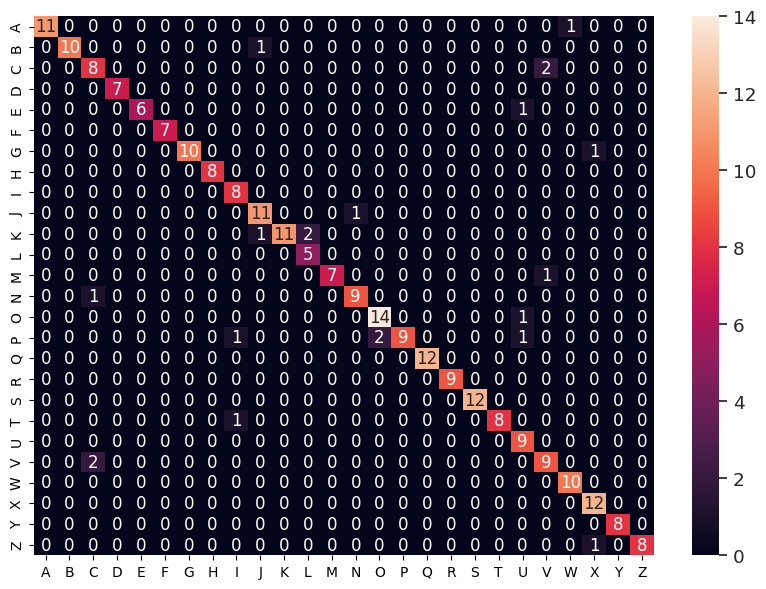

In [38]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")

# Acknowledgements
I have found these resources useful while writing this notebook:
1. [anastasiialobanova's My_CoAtNet Kaggle notebook](https://www.kaggle.com/code/anastasiialobanova/my-coatnet)
2. [xmu-xiaoma666's implementation of CoAtNet](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
3. [https://m0nads.wordpress.com/tag/self-attention/](https://github.com/xmu-xiaoma666/External-Attention-pytorch/blob/master/model/attention/CoAtNet.py)
4. [chinhsuanwu's implementation of CoAtNet](https://github.com/chinhsuanwu/coatnet-pytorch/blob/master/coatnet.py)